In [18]:
from pathlib import Path
import pickle

import h5py
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch.nn.functional import pad
from tqdm.auto import tqdm

In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append(str(Path(".").resolve().parent.parent))

from berp.datasets import BerpDataset, NestedBerpDataset

In [53]:
story_name = "old-man-and-the-sea"
subject = 1
run = 2

aligned_words = "word.csv"
aligned_phonemes = "phoneme.csv"

stimulus = "old-man-and-the-sea/run2.pkl"

# run_Xy = "../../workflow/heilbron2022/data/run_Xy/old-man-and-the-sea/sub1/run1.h5"
run_Xy = "/home/jgauthie/om2/others/heilbron2022/notebooks/exported/Xy/words_proba/sub1/run2.h5"

target_sample_rate = 128
output_path = "old-man-and-the-sea.sub1.run2.pkl"

## Load and process natural language stimulus

In [54]:
with Path(stimulus).open("rb") as f:
    story_stim = pickle.load(f)
    
assert story_stim.name == story_name

In [55]:
# Variable onset features are simply a variable onset intercept,
# word features and word surprisals.
X_variable = torch.concat(
    [torch.ones_like(story_stim.word_surprisals).unsqueeze(1),
     story_stim.word_features,
     story_stim.word_surprisals.unsqueeze(1)],
    dim=1)
variable_feature_names = ["recognition_onset"] + story_stim.word_feature_names + ["word_surprisal"]

assert X_variable.shape[1] == len(variable_feature_names)

## Load design matrix data

In [56]:
with h5py.File(run_Xy) as f:
    assert subject == f.attrs["subject"]
    assert run == f.attrs["run"]
    
    X = f["X"][()]
    y = f["y"][()].T
    
    sensor_names = f.attrs["ch_names"]
    ts_feature_names = f.attrs["feature_names"]
    sfreq = f.attrs["sfreq"]

In [57]:
assert X.shape[0] == y.shape[0]
assert X.shape[1] == len(ts_feature_names)
assert y.shape[1] == len(sensor_names)

## Load aligned word/phoneme presentation data

In [70]:
word_aligned_df = pd.read_csv(aligned_words, index_col=[0, 1]).loc[run].reset_index()
phoneme_aligned_df = pd.read_csv(aligned_phonemes, index_col=[0, 1]).loc[run].reset_index()
word_aligned_df

,word_idx,word,onset,offset,token_idx
0,0,WHEN,1.17,1.31,688
1,1,THE,1.31,1.37,689
2,2,WIND,1.37,1.61,690
3,3,WAS,1.61,1.77,691
4,4,IN,1.77,1.87,692
...,...,...,...,...,...
562,541,AND,179.26,179.35,1364
563,542,YOUR,179.35,179.56,1365
564,543,EYES,179.56,179.77,1366
565,544,ARE,179.77,179.83,1367


{16,
 46,
 68,
 116,
 141,
 170,
 199,
 227,
 278,
 301,
 326,
 349,
 370,
 399,
 451,
 503,
 526}

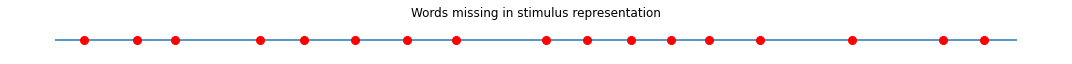

In [77]:
# Not all words in the presentation will be retained in the stimulus: words which
# ended up at the start of an input time series to the model were dropped, because
# the model didn't have those values as targets.
#
# By the above logic, the missing words will likely be distributed roughly evenly
# throughout the stimulus.
words_missing_in_stimulus = set(word_aligned_df.word_idx) - set(story_stim.word_ids.numpy())

plt.figure(figsize=(15, 1))
plt.hlines(0, 0, story_stim.word_ids.max())
plt.plot(list(words_missing_in_stimulus), np.zeros(len(words_missing_in_stimulus)), 'ro', ms=8, mfc='r')
plt.axis('off')
plt.title("Words missing in stimulus representation")
plt.tight_layout()

words_missing_in_stimulus

In [78]:
assert 0 == len(set(story_stim.word_ids.numpy()) - set(word_aligned_df.word_idx)), \
    "Stim words are present which are missing from the aligned data!"

## Load signal data

In [79]:
min_time, max_time = 0, len(X) / sfreq
max_time

163.7265625

In [80]:
# Check compatibility with alignment data.
assert min_time <= word_aligned_df.onset.min()
assert min_time <= phoneme_aligned_df.onset.min()

# NB looks like the last sentence-ish of each run is truncated from the signal
# data. TODO double check this with authors?
# assert max_time >= word_aligned_df.offset.max()
# assert max_time >= phoneme_aligned_df.offset.max()
chopped_words = word_aligned_df.offset >= max_time
chopped_phonemes = phoneme_aligned_df.offset >= max_time
print(f"{chopped_words.sum()}, {chopped_phonemes.sum()} chopped words/phonemes. Dropping.")

word_aligned_df = word_aligned_df[~chopped_words]
phoneme_aligned_df = phoneme_aligned_df[~chopped_phonemes]

46, 134 chopped words/phonemes. Dropping.


In [85]:
# We may have residual phonemes without a corresponding word now. Remove those.
orphaned_phonemes = ~phoneme_aligned_df.word_idx.isin(word_aligned_df.word_idx)
if orphaned_phonemes.any():
    print(f"Also dropping {orphaned_phonemes.sum()} orphaned phonemes.")
    phoneme_aligned_df = phoneme_aligned_df[~orphaned_phonemes]

Also dropping 1 orphaned phonemes.


In [88]:
# Check consistency.
assert set(word_aligned_df.word_idx) == set(phoneme_aligned_df.word_idx)

## Produce BerpDataset representations

In [91]:
# Now produce onset information from canonical aligned data.
# NB this will contain NaNs if there was misalignment above.
word_onsets = word_aligned_df.groupby("word_idx").onset.min().to_dict()
word_onsets = torch.tensor([word_onsets.get(word_id.item(), np.nan)
                            for word_id in story_stim.word_ids])

word_offsets = word_aligned_df.groupby("word_idx").offset.max().to_dict()
word_offsets = torch.tensor([word_offsets.get(word_id.item(), np.nan)
                             for word_id in story_stim.word_ids])

In [95]:
# Compute phoneme onsets relative to word onset.
phoneme_onsets = phoneme_aligned_df.groupby("word_idx") \
    .apply(lambda xs: list(xs.onset - xs.onset.min())).to_dict()
phoneme_onsets = [torch.tensor(phoneme_onsets.get(word_id.item(), [np.nan]))
                  for word_id in story_stim.word_ids]

In [97]:
max_num_phonemes = max(len(onsets) for onsets in phoneme_onsets)
# Sanity check: max_num_phonemes as computed from aligned data should
# match that produced earlier by the natural language stimulus processor
assert max_num_phonemes == story_stim.max_n_phonemes, \
    "%d %d" % (max_num_phonemes, story_stim.max_n_phonemes)

In [98]:
# Pad phoneme onset information
phoneme_onsets = torch.stack([
    pad(onsets, (0, max_num_phonemes - len(onsets)), value=0.)
    if len(onsets) < max_num_phonemes
    else onsets
    for onsets in phoneme_onsets
])

In [105]:
dataset = BerpDataset(
    name=f"{story_name}/{subject}_{run}",
    stimulus_name=story_stim.name,
    sample_rate=sfreq,
    
    phonemes=story_stim.phonemes,
    
    word_onsets=word_onsets,
    word_offsets=word_offsets,
    phoneme_onsets=phoneme_onsets,
    
    X_ts=X,
    ts_feature_names=ts_feature_names,
    
    X_variable=X_variable,
    variable_feature_names=variable_feature_names,
    
    Y=y
)

In [106]:
with Path(output_path).open("wb") as f:
    pickle.dump(dataset, f)